In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Mayank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Mayank/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 1: Data Preparation

In [2]:
# Obtain a structure for the data using Python Programming Language

df = pd.read_csv('jobs.csv', encoding='latin-1')
df.sample()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
1167,395953,DEPT OF DESIGN & CONSTRUCTION,Internal,1,Assistant General Counsel,AGENCY ATTORNEY INTERNE,30086,0,Legal Affairs,F,...,NaN,"For City Employees, please go to Employee Self...",35 Hours,"30-30 Thomson Avenue, LIC, NY",NaN,New York City residency is generally required ...,2019-06-07T00:00:00.000,2019-12-04T00:00:00.000,2019-11-25T00:00:00.000,2019-11-26T00:00:00.000


## Step 2: Identification of Variables

In [3]:
# Following features are required for analysis.

'''
Job ID: reuqired to drop duplicates
Job Category: To identify highest paid skills belonging to category
Salary Range From / Salary Range To: To identify the highest paid jobs
Salary Frequency: Needed to downsample the annual salary ranges to hourly
Preferred Skills: Needed to parse, clean, tokenize skill set based upon TF-IDF Score
Minimum Qual Requirements: Needed to get work experience
'''

cols = [
    'Job ID',
    'Job Category',
    'Salary Range From', 
    'Salary Range To',
    'Preferred Skills', 
    'Minimum Qual Requirements',
    'Salary Frequency'
]

## Step 3: Variable Selection

In [4]:
df = df[cols]

# Remove duplicates based upon Job ID
df = df.drop_duplicates(subset='Job ID')

## Step 5: Missing value or data

In [5]:
# Missing values in below columns

df.isna().mean() * 100

Job ID                        0.000000
Job Category                  0.118483
Salary Range From             0.000000
Salary Range To               0.000000
Preferred Skills             15.343602
Minimum Qual Requirements     0.473934
Salary Frequency              0.000000
dtype: float64

In [6]:
# Only 2 rows show Job Category as NaN, hence dropping the rows
df[df['Job Category'].isna()]

,Job ID,Job Category,Salary Range From,Salary Range To,Preferred Skills,Minimum Qual Requirements,Salary Frequency
0,87990,NaN,42405.0,65485.0,Ã¢â¬Â¢\tExcellent interpersonal and organizat...,1.\tA baccalaureate degree from an accredited ...,Annual
1,97899,NaN,60740.0,162014.0,NaN,1. A baccalaureate degree from an accredited c...,Annual


In [7]:
df = df[~df['Job Category'].isna()]
df = df[~df['Preferred Skills'].isna()]

## Step 4: Feature Engineering

 - Parsing Job Categories based upon the given list in data dictionary
 - Downsample Annual and Daily to Hourly data for Salary ranges
 - Text Preprocessing (Preferred Skills and Minimum Qual Requirements)
     - Tokenize
     - Remove Stop Words
     - Remove multiple spaces
     - Remove Special characters (mentioned in Step 5 of assignment document)
     - Lemmatize text data

In [8]:
# Parse Job Categories into tokens as per below list
job_category_list = [
    'Administration & Human Resources',
    'Communications & Intergovernmental Affairs',
    'Constituent Services & Community Programs',
    'Engineering, Architecture, & Planning',
    'Finance, Accounting, & Procurement',
    'Health',
    'Technology, Data & Innovation',
    'Legal Affairs',
    'Building Operations & Maintenance',
    'Policy, Research & Analysis',
    'Public Safety, Inspections, & Enforcement',
    'Social Services',
    'Maintenance & Operations',
    'Technology, Data & Innovation Policy, Research & Analysis',
    'Clerical & Administrative Support',
    'Information Technology & Telecommunications',
    'Community & Business Services',
    'Legal',
    'Legal Policy & Analysis'
]

def parse_job_categories(row):
    return [item for item in job_category_list if item in row]

df['Job Category'] = df.loc[~df['Job Category'].isna(), 'Job Category'].apply(parse_job_categories)

In [9]:
df.sample(5)

,Job ID,Job Category,Salary Range From,Salary Range To,Preferred Skills,Minimum Qual Requirements,Salary Frequency
2315,416193,"[Finance, Accounting, & Procurement]",80000.0,90000.0,Ã¢â¬Â¢\tProject management and problem solvin...,1. A master's degree from an accredited colleg...,Annual
2415,417192,[Administration & Human Resources],35330.0,40629.0,"Ã¢â¬Â¢\tKnowledge of Microsoft Word, Excel, A...",Qualification Requirements A four-year high s...,Annual
1885,409674,"[Engineering, Architecture, & Planning]",69940.0,186555.0,* Construction Manager Certification * Profici...,At least six years of full-time satisfactory e...,Annual
2393,417085,"[Engineering, Architecture, & Planning]",75000.0,85000.0,The ideal candidate will bring the following s...,1. A four-year high school diploma or its educ...,Annual
1298,399009,"[Communications & Intergovernmental Affairs, P...",75000.0,85000.0,Ã¢â¬Â¢\tAbility to work effectively in a team...,1. A baccalaureate degree in architecture from...,Annual


In [10]:
# Downsample Annual and Daily to Hourly data for Salary ranges

df.loc[df['Salary Frequency'] == 'Annual', 'Hourly Salary Range From'] = \
                    df.loc[df['Salary Frequency'] == 'Annual' , 'Salary Range From'] / (52*8*5)

df.loc[df['Salary Frequency'] == 'Annual', 'Hourly Salary Range To'] = \
                    df.loc[df['Salary Frequency'] == 'Annual' , 'Salary Range To'] / (52*8*5)

df.loc[df['Salary Frequency'] == 'Daily', 'Hourly Salary Range From'] = \
                    df.loc[df['Salary Frequency'] == 'Daily' , 'Salary Range From'] / (8)

df.loc[df['Salary Frequency'] == 'Daily', 'Hourly Salary Range To'] = \
                    df.loc[df['Salary Frequency'] == 'Daily' , 'Salary Range To'] / (8)

df.loc[df['Salary Frequency'] == 'Hourly', 'Hourly Salary Range From'] = \
                    df.loc[df['Salary Frequency'] == 'Hourly' , 'Salary Range From']

df.loc[df['Salary Frequency'] == 'Hourly', 'Hourly Salary Range To'] = \
                    df.loc[df['Salary Frequency'] == 'Hourly' , 'Salary Range To']

In [11]:
def tokenize(row):
    return word_tokenize(str(row))

def text_preprocessing(row):
    processed_texts = []

    # Substituting multiple spaces with single space
    processed_text= re.sub(r'\s+', ' ', str(row), flags=re.I)

    # Remove stop words from email text
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    processed_text = pattern.sub('', processed_text)

    # Converting to Lowercase
    processed_text = processed_text.lower()
    
    # Remove all non-ascii characters
    processed_text = ''.join(i for i in processed_text if 48<=ord(i)<58 or 97<=ord(i)<123 or ord(i)==32)
    
    return processed_text

def custom_lemmatizer(row):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    lemma = WordNetLemmatizer()
    new_row = []
    for token, tag in nltk.pos_tag(row):
        pos = tag_map[tag[0]]
        
        if pos != wn.VERB:
            new_row.append(lemma.lemmatize(token, pos))
    return new_row

In [12]:
# Clean, Parse and Tokenize columns Preferred Skills and Minimum Qual Requirements

df['Preferred Skills'] = df['Preferred Skills'].apply(text_preprocessing).apply(tokenize).apply(custom_lemmatizer)
df['Minimum Qual Requirements'] = df['Minimum Qual Requirements'].apply(text_preprocessing).apply(tokenize).apply(custom_lemmatizer)

## Step 6: Analysis

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=500,
                                 tokenizer=lambda x: x,
                                 preprocessor=lambda x: x,
                                 token_pattern=None,
                                 ngram_range=(1,3)
                                )

In [14]:
X = tfidfconverter.fit_transform(df.loc[df['Hourly Salary Range To'].nlargest(50).index, 'Preferred Skills']).toarray()

data = dict(zip(tfidfconverter.get_feature_names(), tfidfconverter.idf_))
idf_df = pd.DataFrame(data=data, index=np.arange(0,1)).T

# Based upon below tf-idf vocabulary, we find and create a list of skills 
# which can be matched to get the highest paid skills

idf_df.sort_values(0, ascending=False).head()

,0
public health,4.238678
calculation,3.833213
property management,3.833213
diverse building,3.833213
investigation,3.833213


In [15]:
list_of_skills = [
    'azure',
    'teamwork',
    'property management',
    'civil engineering',
    'microsoft office',
    'design construction',
    'project management',
    'electrical engineering',
    'developer',
    'pmp certification',
    'leadership',
    'customer service',
    'verbal communication',
    'analytical',
    'strategic communicator',
    'construction',
    'administrative',
    'creative thinker',
    'contract engineering',
    'finance',
    'real estate',
    'administration',
    'powerpoint',
    'autocad',
    'housing development',
    'asset management',
    'innovation',
    'legal'
]

In [16]:
def match_preferred_skills(row):
    return [item for item in list_of_skills if item in row]

df['Match Preferred Skills'] = df.loc[~df['Preferred Skills'].isna(), 'Preferred Skills'].apply(match_preferred_skills)

In [17]:
high_skills = {}

for row in df.loc[df['Hourly Salary Range To'].sort_values(ascending=False).index].itertuples():
    if len(high_skills.values()) < 10:
        
        for item in row[-1]:
            if high_skills.get(item):
                high_skills.get(item).append(row[1])
            else:
                job_ids = [row[1]]
                high_skills[item] = job_ids
    else:
        
        break

In [18]:
list_job_ids = []

for v in high_skills.values():
    for i in v:
        list_job_ids.append(i)

### Step 6a : What are the highest paid Skills in the US market

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

df_skill_salary = pd.DataFrame(columns=['skill','hourly_salary_range_from','hourly_salary_range_to'])
d = {}
i = 0

for k,v in high_skills.items():
    if i < 10:
        i += 1
        d['skill'] = k
        d['hourly_salary_range_to'] = df.loc[df['Job ID']==v[0], 'Hourly Salary Range To'].values[0]
        d['hourly_salary_range_from'] = df.loc[df['Job ID']==v[-1], 'Hourly Salary Range From'].values[0]
    else:
        break

    df_skill_salary = pd.concat([df_skill_salary, pd.DataFrame(d, index=[0])])

/Users/Mayank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [20]:
df_skill_salary

,hourly_salary_range_from,hourly_salary_range_to,skill
0,42.757692,108.277404,leadership
0,41.512500,108.052404,developer
0,41.512500,108.052404,finance
0,100.762019,108.052404,innovation
0,42.757692,105.089904,analytical
0,41.512500,104.444231,administration
0,34.633654,104.444231,construction
0,41.512500,104.444231,powerpoint
0,36.220192,93.459135,legal
0,42.757692,90.865385,teamwork


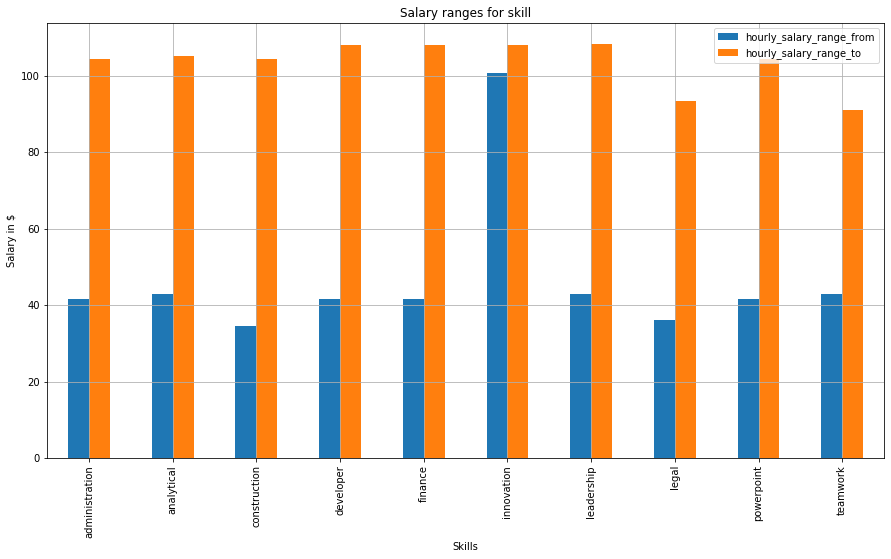

In [21]:
# Plot Salary ranges in a bar chart for each Skill

df_skill_salary.groupby('skill').mean().plot(kind='bar', figsize=(15,8))
plt.ylabel('Salary in $')
plt.xlabel('Skills')
plt.title('Salary ranges for skill')
plt.grid()
plt.show()

## Step 6b : List of Job Categories for above mentioned niche skills

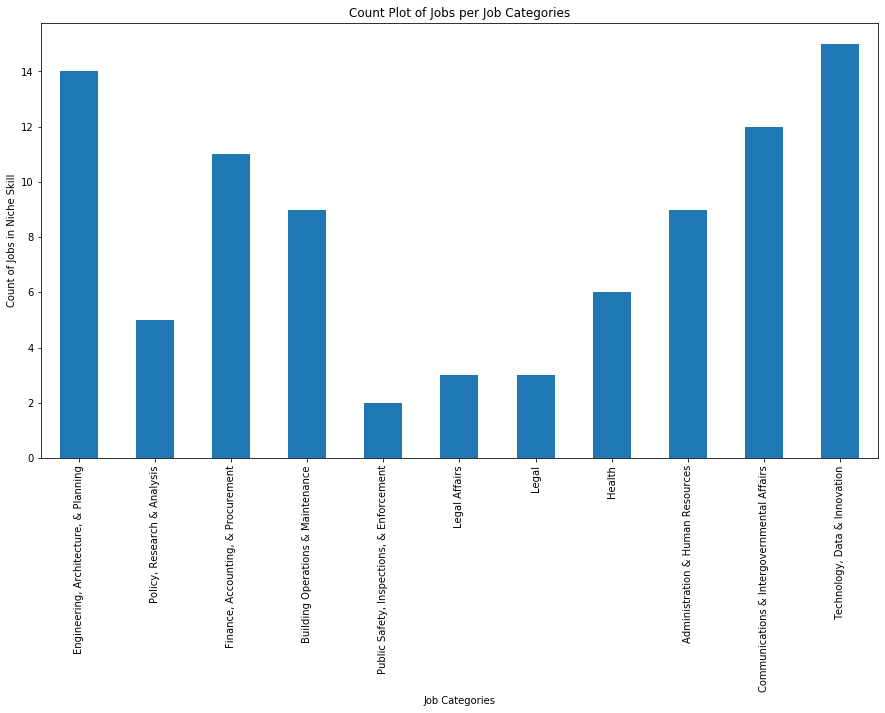

In [22]:
ls = []
d = {}
i = 0

for item in df.loc[df['Job ID'].isin(list(set(list_job_ids))), 'Job Category'].values:
    i += 1
    for value in item:
        d[value] = i
        ls.append(value)

pd.DataFrame(d, index=[0]).T.plot(figsize=(15,8), kind='bar', legend=False)
plt.xticks(rotation=90)
plt.xlabel('Job Categories')
plt.ylabel('Count of Jobs in Niche Skill')
plt.title('Count Plot of Jobs per Job Categories')
plt.show()

In [23]:
numbers = {
    'one':1,
    'two':2,
    'three':3,
    'four':4,
    'five':5,
    'six':6,
    'seven':7,
    'eight':8,
    'nine':9,
    'ten':10,
    'eleven':11,
    'twelve':12,
    'thirteen':13,
    'fourteen':14,
    'fifteen':15,
    'sixteen':16,
    'seventeen':17,
    'eighteen':18,
    'nineteen':19,
    'twenty':20,
    'onehalf':1.5
}

def get_experience(row):

    for i, item in enumerate(row):
        if item.startswith('year'):
            return (str(numbers.get(prv_word, prv_word)))

        prv_word = item

df['work_experience'] = df['Minimum Qual Requirements'].apply(get_experience)

In [24]:
df_new = df.copy()

df_new = pd.concat([df_new, df_new['Job Category'].apply(pd.Series)], axis=1)
df_new.rename(columns = {0:'job_category_0',
              1:'job_category_1',
              2:'job_category_2',
              3:'job_category_3',
              4:'job_category_4',
              5:'job_category_5',
              6:'job_category_6',
              7:'job_category_7'}, inplace=True)

In [25]:
df_new = df_new[~df_new.work_experience.isna()]

In [26]:
from sklearn.preprocessing import LabelEncoder
le_jobcat = LabelEncoder()
le_workexp = LabelEncoder()
transformed_job_categories = le_jobcat.fit_transform(df_new['job_category_0'])
transformed_work_experience = le_workexp.fit_transform(df_new['work_experience'])

df_new['job_category_0_transformed'] = transformed_job_categories
df_new['work_experience_transformed'] = transformed_work_experience

In [27]:
zipped = zip(transformed_job_categories.tolist(), le_jobcat.inverse_transform(transformed_job_categories).tolist())
job_categories = list(set(list(zipped)))

## Step 6: Analysis
 - We have plotted a Scatter Plot for depicting Hourly Salary Ranges for Categories based upon Work Experience in Years
     - The graph shows Hourly Salary Range on Y axis, various Job Categories on X axis
     - The graph also differentiates the data as per Work Experience in years (which is identified on a color scale

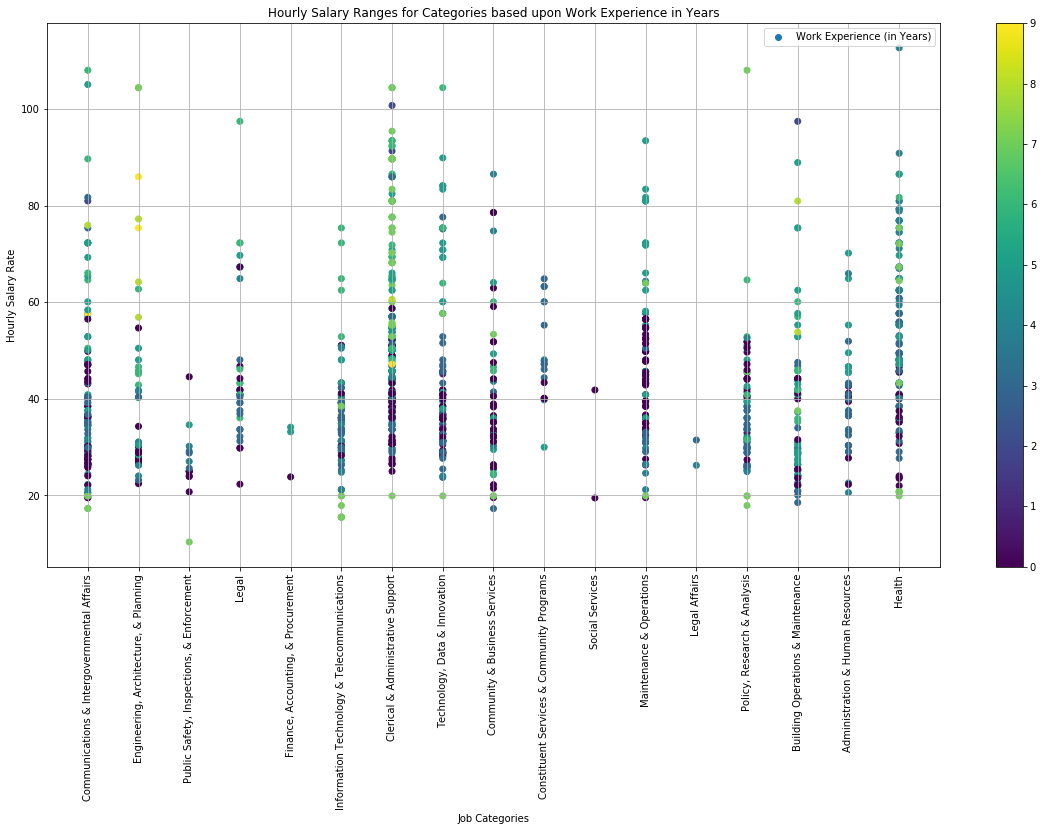

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(20,10))

plt.scatter(
    x='job_category_0_transformed', 
    y='Hourly Salary Range To',
    c='work_experience_transformed',
    marker='o',
    data=df_new
)

plt.legend(['Work Experience (in Years)'])
plt.colorbar()
plt.grid()

plt.xlabel('Job Categories')
plt.ylabel('Hourly Salary Rate')
plt.title('Hourly Salary Ranges for Categories based upon Work Experience in Years')
#plt.xticks(ticks=[i[0] for i in job_categories], labels=[i[1] for i in job_categories], rotation=90)

ax.set_xticks(ticks=range(0,17))
ax.set_xticklabels([i[1] for i in job_categories], rotation=90)

plt.show()